# Algorytmy macierzowe - zadanie nr 1 - Mnożenie macierzy

"2. Proszę napisać mnożenie qxq macierzy FEM i FEM używając algorytmu mnożenia blokowego i dobrać optymalną kolejność pętli oraz rozmiar bloków"

Marcin Hawryluk, Norbert Wolniak <br>grupa: piątek 12:50B <hr>

## Python 3

In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import pandas as pd

Do implementacji wybraliśmy język Python 3 wraz z biblioteką do obliczeń numerycznych numpy, która pozwala operować na macierzach, implementowanych bezpośrednio w języku C.

### Generowanie macierzy

Macierze, których będziemy używać, wygenerowaliśmy za pomocą dostarczonej procedury massmatrix, napisanej w środowisku Octave. Macierze zapisaliśmy w postaci pliku tekstowego, a następnie odczytaliśmy w Pythonie za pomocą poniższej funkcji.

W poniższej pracy przeanalizujemy mnożenie na macierzach typu FEM, czyli pochodzących z obliczeń w ramach Metody Elementów Skończonych, która służy do aproksymacji rozwiązań równań różniczkowych.

In [2]:
def read_matrix(file_name):
    with open(file_name, 'r') as file:
        for line in file:
            if line.strip() == '':
                continue
            if line[0] == '#':
                if line[2:6] == "rows":
                    _, _, size = line.split()
                    size = int(size)
                    matrix = np.zeros((size, size))
            else:
                row, col, val = line.split(' ')
                matrix[int(row)-1, int(col)-1] = val
            
    return matrix

In [3]:
matrix_small = read_matrix("matrices/fem_1210_16x16.txt")
matrix_small

array([[0.11111111, 0.05555556, 0.        , 0.        , 0.05555556,
        0.02777778, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.05555556, 0.11111111, 0.        , 0.        , 0.02777778,
        0.05555556, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.11111111, 0.05555556, 0.        ,
        0.        , 0.05555556, 0.02777778, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.05555556, 0.11111111, 0.        ,
        0.        , 0.02777778, 0.05555556, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.05555556, 0.02777778, 0.        , 0.        , 0.11111111,
        0.05555556, 0.        , 

### Procedura mnożenia macierzy

#### Klasyczna funkcja  w 6 wersjach

Poniżej znajduje się implementacja klasycznej procedury mnożenia macierzy w sześciu wersjach, różniących się jedynie kolejnością zagnieżdzonych pętli.

In [4]:
def mm_ijp(matrix_a, matrix_b):
    (m, n), k = matrix_a.shape, matrix_b.shape[1]
    matrix_c = np.zeros((m, k), dtype=np.float64)
    for i in range(m):
        for j in range(k):
            for p in range(n):
                matrix_c[i, j] += matrix_a[i, p] * matrix_b[p, j]
    return matrix_c

def mm_ipj(matrix_a, matrix_b):
    (m, n), k = matrix_a.shape, matrix_b.shape[1]
    matrix_c = np.zeros((m, k), dtype=np.float64)
    for i in range(m):
        for p in range(n):
            for j in range(k):
                matrix_c[i, j] += matrix_a[i, p] * matrix_b[p, j]
    return matrix_c

def mm_jip(matrix_a, matrix_b):
    (m, n), k = matrix_a.shape, matrix_b.shape[1]
    matrix_c = np.zeros((m, k), dtype=np.float64)
    for j in range(k):
        for i in range(m):
            for p in range(n):
                matrix_c[i, j] += matrix_a[i, p] * matrix_b[p, j]
    return matrix_c

def mm_jpi(matrix_a, matrix_b):
    (m, n), k = matrix_a.shape, matrix_b.shape[1]
    matrix_c = np.zeros((m, k), dtype=np.float64)
    for j in range(k):
        for p in range(n):
            for i in range(m):
                matrix_c[i, j] += matrix_a[i, p] * matrix_b[p, j]
    return matrix_c

def mm_pij(matrix_a, matrix_b):
    (m, n), k = matrix_a.shape, matrix_b.shape[1]
    matrix_c = np.zeros((m, k), dtype=np.float64)
    for p in range(n):
        for i in range(m):
            for j in range(k):
                matrix_c[i, j] += matrix_a[i, p] * matrix_b[p, j]
    return matrix_c

def mm_pji(matrix_a, matrix_b):
    (m, n), k = matrix_a.shape, matrix_b.shape[1]
    matrix_c = np.zeros((m, k), dtype=np.float64)
    for p in range(n):
        for j in range(k):
            for i in range(m):
                matrix_c[i, j] += matrix_a[i, p] * matrix_b[p, j]
    return matrix_c

W celu weryfikacji poprawności powyższych funkcji, porównujemy wynik z macierzą otrzymaną przy użyciu operatora mnożenia macierzy dostępnego w bibliotece numpy:

In [5]:
def mm_test(matrix_a, matrix_b):
    matrix_c = matrix_a @ matrix_b
    res = True
    for mm in [mm_ijp, mm_ipj, mm_jip, mm_jpi, mm_pij, mm_pji]:
        if not np.allclose(matrix_c, mm(matrix_a, matrix_b)):
            print("{} not correct!".format(mm.__name__))
            res = False
    if res:
        print("OK")

mm_test(matrix_small, matrix_small)

OK


#### Procedura mnożenia blokowego macierzy

Następnie implementujemy algorytm mnożenia blokowego, w ramach którego dzielimy macierze wejściowe na mniejsze, rozłączne podmacierze, na których następnie wykonujemy mnożenia i dodawania. Funkcja jako trzeci argument przyjmuje rozmiar podmacierzy; przyjęliśmy, że będziemy dzielić na macierze kwadratowe (z wyjątkiem skrajnych), jednak poniższą funkcję  można by uogólnić, aby można było zadać inny podział. W celu uzyskania iloczynu dwóch podmacierzy, wykorzystujemy klasyczną funkcję w wersji ijp.

In [6]:
def mm_block(matrix_a, matrix_b, block_size):
    (m, n), k = matrix_a.shape, matrix_b.shape[1]
    matrix_c = np.zeros((m, k))
    
    for i in range(0, m, block_size):
        ib = min(m - i, block_size)
        for j in range(0, k, block_size):
            jb = min(n - j, block_size)
            for p in range(0, n, block_size):
                pb = min(k - p, block_size)
                matrix_c[i:i+ib, j:j+jb] += mm_ijp(matrix_a[i:i+ib, p:p+pb],
                                                                   matrix_b[p:p+pb, j:j+jb])
    return matrix_c

Weryfikujemy poprawność powyższej implementacji:

In [7]:
def mm_block_test(matrix_a, matrix_b):
    matrix_c = matrix_a @ matrix_b
    res = True
    for block_size in range(1, 20):
        if not np.allclose(matrix_c, mm_block(matrix_a, matrix_b, block_size)):
            print("{} incorrect block size!".format(block_size))
            res = False
    if res:
        print("OK")

mm_block_test(matrix_small, matrix_small)

OK


"1. Proszę wybrać dwie możliwie największe macierze A i B ze swoich dwóch rodzin macierzy, takie żeby zgadzały się ich rozmiary, oraz przemnożyć je A*B swoim optymalnym algorytmem (tak duże macierze jakie da się w czasie kilku-kilkudziesięciu minut przemnożyć na Państwa laptopie)"

In [8]:
matrix = read_matrix("matrices/fem_1420_81x81.txt")
print(matrix.shape)

(81, 81)


"2. Proszę narysować schemat niezerowych wartości swoich dwóch macierzy (używając komendy spy(A), spy(B) MATLABa) oraz macierzy wynikowej A*B"

<img src="matrices/1550_spy.jpeg" width=500 height=500 />
<img src="matrices/1550_spy_mult.jpeg" width=500 height=500 />

### Pomiar czasów

"3. Proszę zmierzyć czas mnożenia tych wybranych dwóch dużych macierzy dla różnej kolejności pętli w algorytmie mnożenia macierzy. Proszę narysować tabelkę: kolejność pętli (6 możliwości) versus czasy mnożenia"

In [15]:
def compare_mult_times(matrix_a, matrix_b):
    times = {}
    for mm in [mm_ijp, mm_ipj, mm_jip, mm_jpi, mm_pij, mm_pji]:
        start = time()
        mm(matrix_a, matrix_b)
        times[mm.__name__[3:]] = time() - start
        
    df = pd.DataFrame(times.values(), times.keys(), ["times [s]"])
    df.plot(
        kind='bar',
        figsize=(10, 5),
        xlabel='loop order',
        ylabel='multiplication time [s]',
        colormap='Set3'
    )
    
    return df

,times [s]
ijp,0.231505
ipj,0.231492
jip,0.228723
jpi,0.228790
pij,0.225094
pji,0.225077


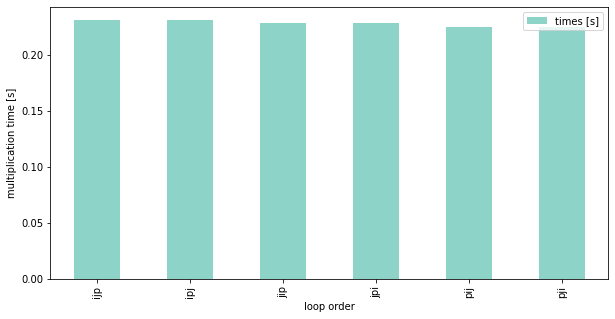

In [17]:
compare_mult_times(matrix, matrix)

Na powyższych wynikach nie można zaobserwować wyraźnej różnicy na korzyść którejkolwiek z wersji procedury.

"4. Proszę wybrać jedną kolejność pętli i następnie dla swoich dwóch macierzy A i B zmierzyć czasy mnożenia w algorytmie mnożenia blokowego. Proszę narysować wykres: oś x rozmiar bloków, oś y czas mnożenia"

In [26]:
def compare_block_times(matrix_a, matrix_b):
    times = {}
    
    for block_size in range(1, 100, 5):
        start = time()
        mm_block(matrix_a, matrix_b, block_size)
        times[block_size] = time() - start
    
    df = pd.DataFrame(times.values(), times.keys(), ["times [s]"])
    df.plot(
        figsize=(10, 10),
        xlabel='block size',
        ylabel='multiplication time [s]',
        color="#4a4e69",
        linewidth=3,
        markersize=10,
        marker='o'
    )
    
    return df

,times [s]
1,1.988832
6,0.254638
11,0.237961
16,0.230232
21,0.227438
26,0.228938
31,0.234069
36,0.226634
41,0.223346
46,0.221576


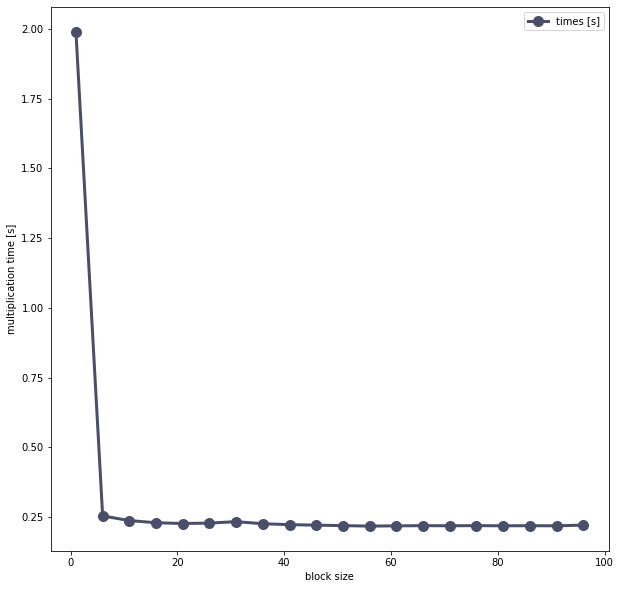

In [27]:
compare_block_times(matrix, matrix)

Zdecydowanie największy czas został zaobserwowany dla rozmiaru bloku wynoszącego 1. Wynika to najprawdopodobniej z bardzo dużej liczby wywołań funkcji, które jest dość kosztowne czasowo. Dla pozostałych wielkości bloków nie zaobserwowaliśmy znacznych różnic.

<hr>

Na brak różnic w czasach w powyższych testach najpewniej wpłynął wybór interpretowalnego języka programowania. Biblioteka numpy, mimo iż napisana w C, dokonuje wielu optymalizacji, które nie są oczywiste dla użytkownika, co mogło także zaburzyć spodziewany efekt. W związku z tym, przeprowadziliśmy ponowne testy, tym razem napisane w całości w języku C.

## C

### Generowanie macierzy

W celu przeprowadzenia testów na macierzach o dużych wymiarach, odczytaną macierz powiększamy do zadanych rozmiarów, powtarzając okresowo wartości (matrix[i][j] = matrix[i%n][j%n]). Wygenerowanie macierzy o dużych rozmiarach w środowisku Octave/Matlab zajęłoby dużo czasu.

```c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <sys/times.h>
#include <string.h>

double** read_matrix(char* filename, int m){
    FILE* f;
    f = fopen(filename, "r");

    char * buffer = NULL;
    size_t len = 0;
    ssize_t read;
    int n;
    double ** matrix;

    while ((read = getline(&buffer, &len, f)) != -1) {
        char *token;
        token = strtok(buffer, " ");
   
        if(strcmp(token, "#") == 0){
            token = strtok(NULL, " ");
            if(strcmp(token, "rows:") == 0){
                token = strtok(NULL, " ");
                n = atoi(token);
                matrix = empty_arr(n * m, n * m);
            }
        }
        else{
            int i, j;
            double val;
            i = atoi(token);
            token = strtok(NULL, " ");
            j = atoi(token);
            token = strtok(NULL, " ");
            val = atof(token);
            matrix[i-1][j-1] = val;
        }
    }  

    for (int i = n ; i < n * m ; i++)
    {
        for (int j = n ; j < n * m ; j++)
        {
            matrix[i][j] = matrix[i%n][j%n];
        }
    }

    fclose(f);
    return matrix;
}
```

### Procedura mnożenia macierzy

#### Klasyczna funkcja w 6 wersjach

Poniższy kod służy do mnożenia macierzy kwadratowych, gdyż na takich będziemy dokonywać porównań, jednak w prosty sposób można by uogólnić te funkcje dla dowolnych macierzy o zgodnych wymiarach, na wzór procedury napisanej poprzednio w języku Python.

```c
void matmul_ijp(double** C, double** A, double** B, int n){
    for (int i = 0 ; i < n ; i++){
        for (int j = 0 ; j < n ; j++){
            for (int p = 0 ; p < n ; p++){
                C[i][j] = C[i][j] + A[i][p] * B[p][j];
            }
        }
    }
}

void matmul_ipj(double** C, double** A, double** B, int n){
    for (int i = 0 ; i < n ; i++){
        for (int p = 0 ; p < n ; p++){
            for (int j = 0 ; j < n ; j++){
                C[i][j] = C[i][j] + A[i][p] * B[p][j];
            }
        }
    }
}

void matmul_jip(double** C, double** A, double** B, int n){
    for (int j = 0 ; j < n ; j++){
        for (int i = 0 ; i < n ; i++){
            for (int p = 0 ; p < n ; p++){
                C[i][j] = C[i][j] + A[i][p] * B[p][j];
            }
        }
    }
}

void matmul_jpi(double** C, double** A, double** B, int n){
    for (int j = 0 ; j < n ; j++){
        for (int p = 0 ; p < n ; p++){
            for (int i = 0 ; i < n ; i++){
                C[i][j] = C[i][j] + A[i][p] * B[p][j];
            }
        }
    }
}

void matmul_pij(double** C, double** A, double** B, int n){
    for (int p = 0 ; p < n ; p++){
        for (int i = 0 ; i < n ; i++){
            for (int j = 0 ; j < n ; j++){
                C[i][j] = C[i][j] + A[i][p] * B[p][j];
            }
        }
    }
}

void matmul_pji(double** C, double** A, double** B, int n){
    for (int p = 0 ; p < n ; p++){
        for (int j = 0 ; j < n ; j++){
            for (int i = 0 ; i < n ; i++){
                C[i][j] = C[i][j] + A[i][p] * B[p][j];
            }
        }
    }
}
```

#### Procedura mnożenia blokowego macierzy

```c
void matmul_blocking(double** C, double** A, double** B, int n, int block_size){
  for (int i = 0 ; i < n ; i=i+block_size){
    for (int p = 0 ; p < n ; p=p+block_size){
      for (int j = 0 ; j < n ; j=j+block_size){
            
        for (int ib = i; ib < i+block_size; ib++){
          for (int pb = p; pb < p+block_size; pb++){
            for (int jb = j; jb < j+block_size; jb++){
                C[ib][jb] = C[ib][jb] + A[ib][pb]*B[pb][jb];
            }
          }
        }
      }
    }
  }
}
```

### Pomiar czasów

Czasy obliczone w programie zapisaliśmy do pliku csv, aby następnie w Pythonie utworzyć na ich podstawię wizualizację.

```c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <sys/times.h>
#include <string.h>

double** new_arr(int N, int M){
    double** arr = malloc(N * sizeof(double*));
    for (int i = 0 ; i < N ; i++){
        arr[i] = calloc(M, sizeof(double));
        for(int j = 0 ; j < M ; j++) arr[i][j] = rand();
    }
    return arr;
}

double** empty_arr(int N, int M){
    double** arr = malloc(N * sizeof(double*));
    for (int i = 0 ; i < N ; i++){
        arr[i] = calloc(M, sizeof(double));
    }
    return arr;
}

int main()
{
    srand ( time ( NULL));
    clock_t start, end;

    double* ijp_times = malloc(1 * sizeof(double));
    double* ipj_times = malloc(1 * sizeof(double));
    double* jip_times = malloc(1 * sizeof(double));
    double* jpi_times = malloc(1 * sizeof(double));
    double* pij_times = malloc(1 * sizeof(double));
    double* pji_times = malloc(1 * sizeof(double));
    double* blocking_times = malloc(200 * sizeof(double));

    int multipl = 10;
    double** A = read_matrix("fem_1550_196x196.txt", multipl);
    double** B = read_matrix("fem_1550_196x196.txt", multipl);
    double** C;
    int n = 196 * multipl;
    
    
    printf("size %d\n", n);
    C = empty_arr(n, n);
    start = clock();
    matmul_ijp(C, A, B, n);
    end = clock();
    ijp_times[0] = ((double)(end - start)) / CLOCKS_PER_SEC;
    printf("%f\n", ijp_times[0]);

    remove_arr(n, C);

    C = empty_arr(n, n);
    start = clock();
    matmul_ipj(C, A, B, n);
    end = clock();
    ipj_times[0] = ((double)(end - start)) / CLOCKS_PER_SEC;
    remove_arr(n, C);

    C = empty_arr(n, n);
    start = clock();
    matmul_jip(C, A, B, n);
    end = clock();
    jip_times[0] = ((double)(end - start)) / CLOCKS_PER_SEC;
    remove_arr(n, C);

    C = empty_arr(n, n);
    start = clock();
    matmul_jpi(C, A, B, n);
    end = clock();
    jpi_times[0] = ((double)(end - start)) / CLOCKS_PER_SEC;
    remove_arr(n, C);

    C = empty_arr(n, n);
    start = clock();
    matmul_pij(C, A, B, n);
    end = clock();
    pij_times[0] = ((double)(end - start)) / CLOCKS_PER_SEC;
    remove_arr(n, C);

    C = empty_arr(n, n);
    start = clock();
    matmul_pji(C, A, B, n);
    end = clock();
    pji_times[0] = ((double)(end - start)) / CLOCKS_PER_SEC;
    remove_arr(n, C);
    

    int k = 0;
    for (int block_size = 1 ; block_size <= n ; block_size = block_size + 1){
        if (n % block_size != 0) continue;
        printf("block size %d\n", block_size);
        
        C = empty_arr(n, n);
        start = clock();
        matmul_blocking(C, A, B, n, block_size);
        end = clock();
        blocking_times[k] = ((double)(end - start)) / CLOCKS_PER_SEC;
        remove_arr(n, C);
        k++;
    }

    remove_arr(n,A);
    remove_arr(n,B);

    FILE *f_matmul;
    f_matmul = fopen("matmul_times.csv", "w+");
    fprintf(f_matmul,"Size, IJP, IPJ, JIP, JPI, PIJ, PJI\n");
    fprintf(f_matmul,"%d, %f, %f, %f, %f, %f, %f\n", n, ijp_times[0], ipj_times[0],
            jip_times[0], jpi_times[0], pij_times[0], pji_times[0]);


    FILE *f_blocking;
    f_blocking = fopen("blocking_times.csv", "w+");
    fprintf(f_blocking,"BlockSize, Time[s]\n");
    k = 0;
    for (int block_size = 1 ; block_size <= n ; block_size++){
        if (n % block_size != 0) continue;
        fprintf(f_blocking,"%d, %f\n", block_size, blocking_times[k]);
        k++;
    }

    fclose(f_matmul);
    fclose(f_blocking);
    free(ijp_times);
    free(ipj_times);
    free(jip_times);
    free(jpi_times);
    free(pij_times);
    free(pji_times);
    free(blocking_times);
    return 0;
}
```

#### porównanie czasów dla różnych kolejności pętli

matrix size: 1960


,times[0]
IJP,59.754282
IPJ,28.979273
JIP,30.432951
JPI,28.389494
PIJ,30.220525
PJI,29.364368


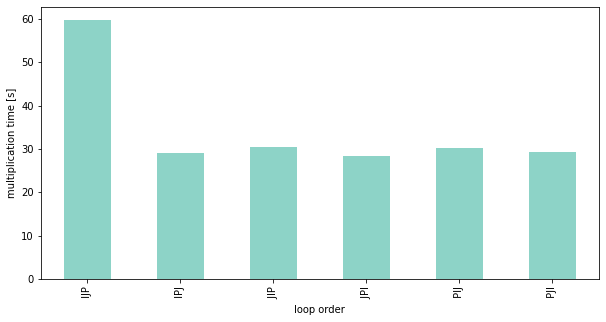

In [44]:
def show_mult_times(file):
    data = pd.read_csv(file)
    print(f'matrix size: {data["Size"][0]}')
    data = data.transpose().drop('Size').rename(columns={0: "times[0]"})

    
    data.plot(
        kind='bar', 
        xlabel='loop order', 
        ylabel='multiplication time [s]', 
        figsize=(10, 5),
        colormap='Set3',
        legend=None
    )
    
    return data
    
show_mult_times("matmul_times.csv")

Najlepsze czasy otrzymaliśmy dla wersji ipj oraz jpi. Różnica w czasach dla różnej kolejności odwołań do poszczególnych pól wynika z czasu potrzebnego na przesłanie wartości z pamięci RAM do rejestrów procesora oraz z wykorzystania pamięci pomocniczej cache. Macierze są trzymane w pamięci kolumnami, więc kopiując do szybkiej pamięci całą kolumnę (lub jej część), a następnie odczyt kolejnych wartości z tej samej kolumny, pozwala na zauważalne zmniejszenia czasu procedury.

#### porównanie czasów dla różnych rozmiarów bloków

,BlockSize,Time[s]
0,1,59.754282
1,2,36.794170
2,4,31.243284
3,5,30.350315
4,7,28.979273
5,8,28.870096
6,10,30.836188
7,14,28.512718
8,20,30.432951
9,28,28.644196


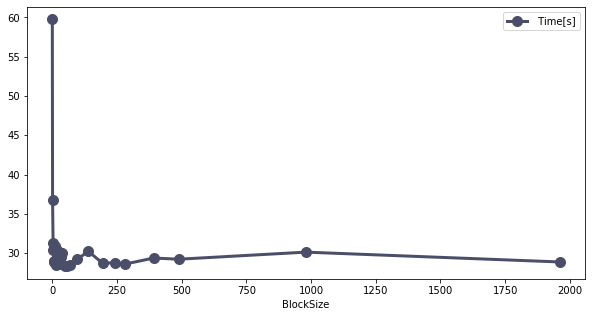

In [46]:
def show_block_times(file):
    data = pd.read_csv(file)
    
    data.plot(
        x='BlockSize',
        color="#4a4e69",
        figsize=(10, 5),
        marker='o',
        markersize=10, 
        linewidth=3
    )
    
    return data
    
show_block_times("blocking_times.csv")

Zgodnie z oczekiwaniami, największy czas obserwujemy dla minimalnego rozmiaru bloku. Najlepszy czas otrzymaliśmy dla rozmiaru w okolicach 50. Test został przeprowadzony na komputerze o wielkości pamięci L1 równej 64KB i dla tych parametrów jest to oczekiwana wielkość bloku.

## Liczba operacji zmiennoprzecinkowych

"5. Proszę obliczyć liczbę operacji zmienno-przecinkowych koniecznych do przemnożenia swoich dwóch macierzy"

Aby przemnożyć obie macierze A i B o wymiarach nxn każda potrzeba 2 * n^3 operacji zmiennoprzecinkowych, 
w ogólności dla macierzy n x m * m x k potrzeba 2\*n\*m\*k operacji, ponieważ w celu obliczenia wartości w macierzy wynikowej musimy wykonać m mnożeń oraz m dodawań, a komórek jest n\*k. Wykorzystując procedurę mnożenia blokowego, nie zmienia się łączna liczba operacji.

## Wnioski

* Na czas mnożenia macierzy, oprócz liczby operacji zmiennoprzecinkowych, wpływa także czas potrzebny na dostęp do pamięci i przepisywania wartości do rejestrów.
* Dobierając optymalną kolejność pętli w procedurze mnożenia macierzy jesteśmy w stanie zaoszczędzić czas.
* Ze względu na ograniczoną wielkość pamięci cache, dla dużych macierzy uzyskamy mniejszy czas mnożenia korzystając z procedury mnożenia blokowego, która dzieli dużą macierz na mniejsze fragmenty, których kolumny zmieszczą się w pamięci podręcznej.
* Optymalny rozmiar bloku zależy od parametrów komputera i wielkości typu reprezentowanych danych i można go określić na przykład w sposób doświadczalny.

M. Hawryluk, N. Wolniak. 2021